In [1]:
import pandas as pd
import numpy as np
import spacy
import spacy as displacy
import networkx as nx

import matplotlib.pyplot as plt

In [2]:
!python -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.1/12.8 MB 156.1 kB/s eta 0:01:22
     --------------------------------------- 0.1/12.8 MB 156.1 kB/s eta 0:01:22
     --------------------------------------- 0.1/12.8 MB 242.7 kB/s eta 0:00:53
     --------------------------------------- 0.2/12.8 MB 327.5 kB/s eta 0:00:39
      -------------------------------------- 0.2/12.8 MB 430.1 kB/s eta 0:00:30
      ------------

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
NER = spacy.load("en_core_web_sm")

# Convert the mahabharata PDF to .txt file

In [4]:
import fitz  # PyMuPDF

def pdf_to_text(pdf_path, txt_path):
    # Open the PDF file
    with fitz.open(pdf_path) as pdf_file:
        # Initialize an empty string to store the text
        text = ""
        
        # Iterate through each page of the PDF
        for page_num in range(len(pdf_file)):
            # Get the text of the page
            page_text = pdf_file[page_num].get_text()
            
            # Append the page text to the overall text
            text += page_text
            
    # Write the text to a text file
    with open(txt_path, "w", encoding="utf-8") as txt_file:
        txt_file.write(text)

# Example usage:
pdf_path = r"C:\Users\Nilkamal\mahabharata.pdf"  # Path to your PDF file
txt_path = r"C:\Users\Nilkamal\data\mahabharata.txt"    # Path to save the text file
pdf_to_text(pdf_path, txt_path)


In [5]:
import os

mahabharata_txt_file = [b for b in os.scandir('data') if '.txt' in b.name]

In [6]:
mahabharata_txt_file

[<DirEntry 'mahabharata.txt'>]

In [7]:
book = mahabharata_txt_file[0]
book_text = open(book).read()
book_doc = NER(book_text)

In [8]:
spacy.displacy.render(book_doc, style="ent", jupyter=True)

In [9]:
character_df = pd.read_csv("combined_data_1.csv")

In [10]:
import re
character_df['Characters'] = character_df['Characters'].apply(lambda x: re.sub("[\(].*?[\)]","", x))

In [11]:
character_df

Characters
0      Abhimanyu
1      Adhiratha
2         Adrika
3           Agni
4      Alambusha
..           ...
244     Yaudheya
245       Yayati
246      Yogmaya
247  Yudhisthira
248      Yuyutsu

[249 rows x 1 columns]

sent_entity_df = []

#loop through sentences, store named entity list for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence":sent, "entities":entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)
sent_entity_df.sample(10)

In [13]:
def filter_entity (ent_list, character_df):
    return [ent for ent in ent_list if ent in list(character_df.Characters)]

In [14]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len)>0]
sent_entity_df_filtered.head(10) 

sentence              entities  \
3         (Bhishma, 's, Vow, \n, 4, .)    [Bhishma, Vow \n4]   
5             (And, Bhishma, \n, 5, .)          [Bhishma, 5]   
6     (Devayani, And, Kacha, \n, 6, .)            [Kacha, 6]   
8                   (Yayati, \n, 8, .)           [Yayati, 8]   
12                  (Bhima, \n, 12, .)           [Bhima, 12]   
13                  (Karna, \n, 13, .)           [Karna, 13]   
14                  (Drona, \n, 14, .)           [Drona, 14]   
29       (Krishna, 's, Vow, \n, 29, .)   [Krishna, Vow \n29]   
38    (Bhima, And, Hanuman, \n, 38, .)  [Bhima, Hanuman, 38]   
41  (Duryodhana, Disgraced, \n, 41, .)      [Duryodhana, 41]   

   character_entities  
3           [Bhishma]  
5           [Bhishma]  
6             [Kacha]  
8            [Yayati]  
12            [Bhima]  
13            [Karna]  
14            [Drona]  
29          [Krishna]  
38   [Bhima, Hanuman]  
41       [Duryodhana]

# Create Relationship

In [15]:
window_size = 5
relationship = []

for i in range (sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    #remove duplicate that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list))
                  if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) >1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationship.append({"source":a, "target":b})

In [16]:
relationship_df = pd.DataFrame(relationship)
relationship_df

source     target
0      Bhishma      Kacha
1      Bhishma      Kacha
2      Bhishma      Kacha
3        Kacha     Yayati
4      Bhishma      Kacha
...        ...        ...
15453  Satyaki    Yuyutsu
15454  Yuyutsu  Abhimanyu
15455  Satyaki    Yuyutsu
15456  Yuyutsu  Abhimanyu
15457  Yuyutsu  Abhimanyu

[15458 rows x 2 columns]

In [17]:
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis=1), columns = relationship_df.columns)
relationship_df

source   target
0        Bhishma    Kacha
1        Bhishma    Kacha
2        Bhishma    Kacha
3          Kacha   Yayati
4        Bhishma    Kacha
...          ...      ...
15453    Satyaki  Yuyutsu
15454  Abhimanyu  Yuyutsu
15455    Satyaki  Yuyutsu
15456  Abhimanyu  Yuyutsu
15457  Abhimanyu  Yuyutsu

[15458 rows x 2 columns]

In [18]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()
relationship_df.head(10)

source   target  value
0     Bhishma    Kacha      5
1       Kacha   Yayati      4
2       Bhima   Yayati      2
3       Bhima    Karna    380
4       Drona    Karna    165
5       Bhima  Hanuman     76
6  Duryodhana  Hanuman      3
7      Arjuna   Virata     83
8      Arjuna  Nahusha      3
9     Krishna  Nahusha     12

# Graph analysis and visualization

In [19]:
G = nx.from_pandas_edgelist(relationship_df, 
                           source = "source",
                           target = "target",
                           edge_attr = "value",
                           create_using = nx.Graph())

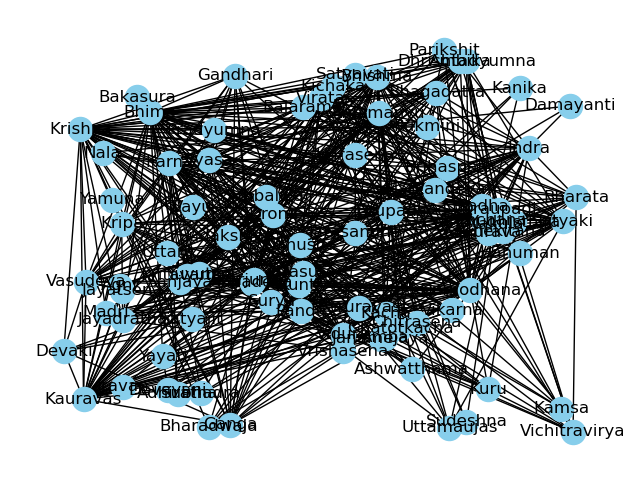

In [20]:
pos = nx.random_layout(G)
#pos = nx.kamada_kawai_layout(G)
fig, ax = plt.subplots(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos, ax = ax)
plt.show()

In [21]:
!pip install pyvis


Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [22]:
from pyvis.network import Network
net =  Network(notebook = True, width = "3000px", height = "800px", bgcolor = "#222222", font_color = "white")
#net.options.physics : False
net.toggle_physics(False)

node_degree = dict(G.degree)

nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("mahabharata.html")

mahabharata.html


In [23]:
dict(G.degree)

{'Bhishma': 37,
 'Kacha': 6,
 'Yayati': 7,
 'Bhima': 48,
 'Karna': 39,
 'Drona': 34,
 'Hanuman': 8,
 'Duryodhana': 53,
 'Arjuna': 45,
 'Virata': 30,
 'Nahusha': 9,
 'Krishna': 43,
 'Bhagadatta': 13,
 'Abhimanyu': 27,
 'Draupadi': 38,
 'Vyasa': 23,
 'Kunti': 27,
 'Gandhari': 14,
 'Janamejaya': 3,
 'Parikshit': 8,
 'Pandu': 24,
 'Vichitravirya': 11,
 'Madri': 7,
 'Kauravas': 39,
 'Ganga': 19,
 'Yamuna': 1,
 'Satyavati': 8,
 'Ambalika': 7,
 'Bharata': 16,
 'Amba': 3,
 'Drupada': 25,
 'Brihaspati': 13,
 'Devayani': 9,
 'Indra': 27,
 'Vidura': 25,
 'Ambika': 7,
 'Kripa': 19,
 'Kuru': 7,
 'Adhiratha': 3,
 'Bharadwaja': 7,
 'Dhrishtadyumna': 21,
 'Ashwatthama': 5,
 'Kanika': 4,
 'Purochana': 8,
 'Nakula': 16,
 'Sahadeva': 19,
 'Bakasura': 1,
 'Jarasandha': 13,
 'Balarama': 12,
 'Pururavas': 1,
 'Kamsa': 5,
 'Ugrasena': 3,
 'Devaki': 7,
 'Jayadratha': 16,
 'Yuyutsu': 6,
 'Vikarna': 12,
 'Yudhisthira': 1,
 'Sanjaya': 20,
 'Satyaki': 27,
 'Vasudeva': 20,
 'Nala': 4,
 'Chitrasena': 10,
 'Jatasura

# Centrality measures

In [24]:
#The most important characters in the mahabharata

In [25]:
#Degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict

{'Bhishma': 0.44047619047619047,
 'Kacha': 0.07142857142857142,
 'Yayati': 0.08333333333333333,
 'Bhima': 0.5714285714285714,
 'Karna': 0.46428571428571425,
 'Drona': 0.40476190476190477,
 'Hanuman': 0.09523809523809523,
 'Duryodhana': 0.6309523809523809,
 'Arjuna': 0.5357142857142857,
 'Virata': 0.3571428571428571,
 'Nahusha': 0.10714285714285714,
 'Krishna': 0.5119047619047619,
 'Bhagadatta': 0.15476190476190477,
 'Abhimanyu': 0.3214285714285714,
 'Draupadi': 0.45238095238095233,
 'Vyasa': 0.2738095238095238,
 'Kunti': 0.3214285714285714,
 'Gandhari': 0.16666666666666666,
 'Janamejaya': 0.03571428571428571,
 'Parikshit': 0.09523809523809523,
 'Pandu': 0.2857142857142857,
 'Vichitravirya': 0.13095238095238093,
 'Madri': 0.08333333333333333,
 'Kauravas': 0.46428571428571425,
 'Ganga': 0.22619047619047616,
 'Yamuna': 0.011904761904761904,
 'Satyavati': 0.09523809523809523,
 'Ambalika': 0.08333333333333333,
 'Bharata': 0.19047619047619047,
 'Amba': 0.03571428571428571,
 'Drupada': 0.2976

<Axes: >

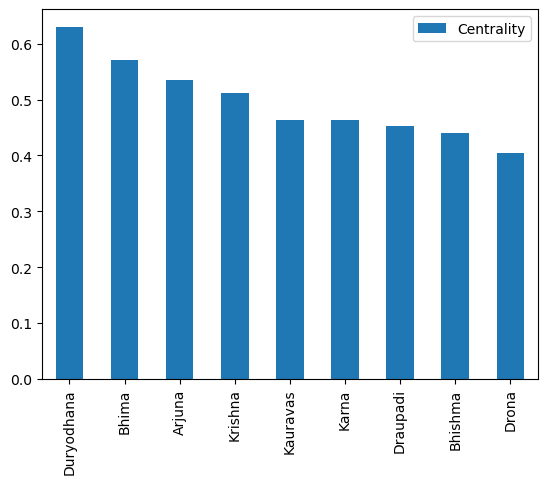

In [26]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient = 'index', columns = ['Centrality'])
degree_df.sort_values('Centrality', ascending = False)[0:9].plot(kind = "bar")

<Axes: >

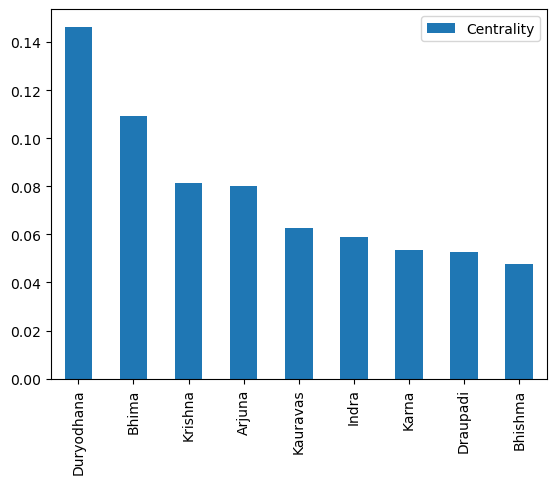

In [27]:
#betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient = 'index', columns = ['Centrality'])
betweenness_df.sort_values('Centrality', ascending = False) [0:9].plot(kind = "bar")

<Axes: >

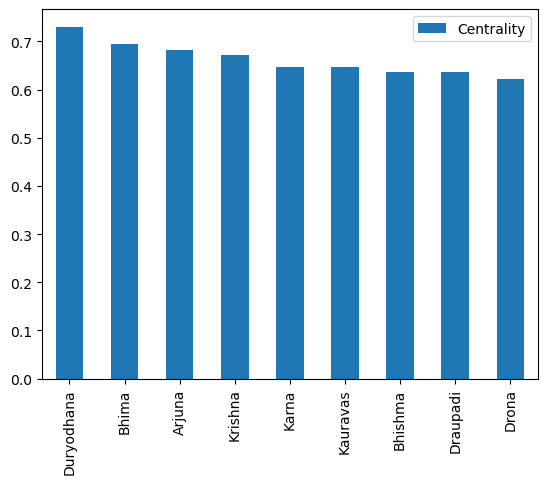

In [28]:
#closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient = 'index', columns = ['Centrality'])
closeness_df.sort_values('Centrality', ascending = False) [0:9].plot(kind = "bar")

In [29]:
#save centraity measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

In [30]:
#community Detection

In [31]:
!pip install python-louvain

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [32]:
import community as community_louvain

In [33]:
communities = community_louvain.best_partition(G)
communities

{'Bhishma': 2,
 'Kacha': 1,
 'Yayati': 1,
 'Bhima': 3,
 'Karna': 2,
 'Drona': 4,
 'Hanuman': 3,
 'Duryodhana': 4,
 'Arjuna': 4,
 'Virata': 1,
 'Nahusha': 1,
 'Krishna': 0,
 'Bhagadatta': 4,
 'Abhimanyu': 4,
 'Draupadi': 3,
 'Vyasa': 3,
 'Kunti': 2,
 'Gandhari': 3,
 'Janamejaya': 3,
 'Parikshit': 3,
 'Pandu': 2,
 'Vichitravirya': 2,
 'Madri': 2,
 'Kauravas': 2,
 'Ganga': 2,
 'Yamuna': 2,
 'Satyavati': 2,
 'Ambalika': 2,
 'Bharata': 1,
 'Amba': 2,
 'Drupada': 4,
 'Brihaspati': 1,
 'Devayani': 1,
 'Indra': 1,
 'Vidura': 2,
 'Ambika': 2,
 'Kripa': 4,
 'Kuru': 2,
 'Adhiratha': 2,
 'Bharadwaja': 4,
 'Dhrishtadyumna': 0,
 'Ashwatthama': 4,
 'Kanika': 1,
 'Purochana': 2,
 'Nakula': 0,
 'Sahadeva': 0,
 'Bakasura': 3,
 'Jarasandha': 0,
 'Balarama': 1,
 'Pururavas': 1,
 'Kamsa': 0,
 'Ugrasena': 0,
 'Devaki': 2,
 'Jayadratha': 4,
 'Yuyutsu': 4,
 'Vikarna': 4,
 'Yudhisthira': 4,
 'Sanjaya': 4,
 'Satyaki': 4,
 'Vasudeva': 3,
 'Nala': 0,
 'Chitrasena': 4,
 'Jatasura': 3,
 'Sudeshna': 1,
 'Kichaka': 1

In [34]:
nx.set_node_attributes(G, communities, 'group')

In [35]:
from pyvis.network import Network
com_net =  Network(notebook = True, width = "3000px", height = "800px", bgcolor = "#222222", font_color = "white")
#node_degree = dict(G.degree)
#nx.set_node_attributes(G, node_degree, 'size')
com_net.toggle_physics(False)

com_net.from_nx(G)
com_net.show("mahabharata_communities.html")

mahabharata_communities.html
